<h1>HW2</h1>

Alan Wu

Graphing portion of the homework

In [5]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [6]:
wcom_data = pd.read_excel('data/WCOM.xlsx')

In [7]:
wcom_data.head()

,Date,Open,High,Low,Close,Volume
0,1997-04-01,22.000,23.250,21.875,23.125,8089414
1,1997-04-02,23.250,23.250,22.500,22.625,4146433
2,1997-04-03,22.500,23.625,22.375,23.250,6233528
3,1997-04-04,23.125,23.500,22.250,22.875,4696940
4,1997-04-07,23.000,23.500,22.875,23.375,6849102


### 1a

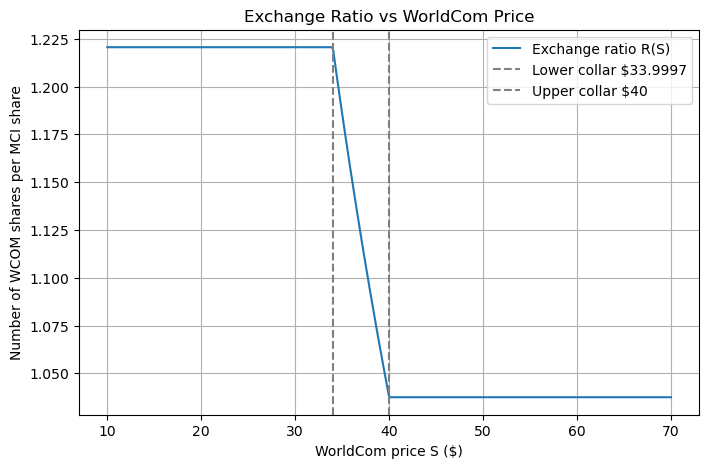

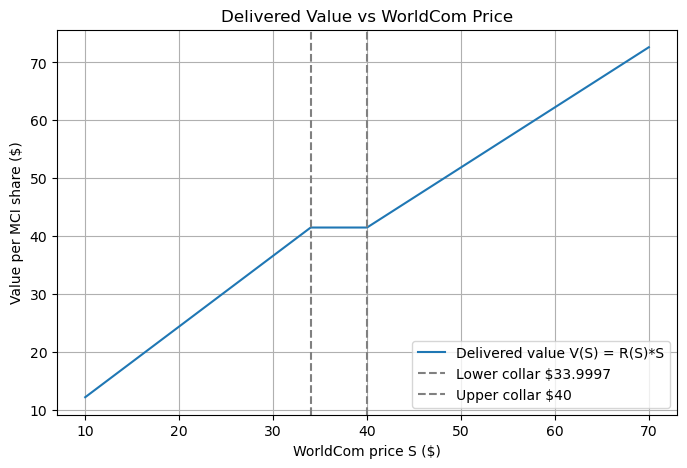

In [9]:
# Price grid for WorldCom stock (S)
S = np.linspace(10, 70, 500)

# Define R(S) piecewise
R = np.piecewise(S, 
    [S < 34, (S >= 34) & (S <= 40), S > 40],
    [1.2206, lambda s: 41.50 / s, 1.0375]
)

# Compute delivered value V(S)
V = R * S

# Plot exchange ratio
plt.figure(figsize=(8,5))
plt.plot(S, R, label="Exchange ratio R(S)")
plt.axvline(34, color='gray', linestyle='--', label="Lower collar $33.9997")
plt.axvline(40, color='gray', linestyle='--', label="Upper collar $40")
plt.xlabel("WorldCom price S ($)")
plt.ylabel("Number of WCOM shares per MCI share")
plt.title("Exchange Ratio vs WorldCom Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot delivered value
plt.figure(figsize=(8,5))
plt.plot(S, V, label="Delivered value V(S) = R(S)*S")
plt.axvline(34, color='gray', linestyle='--', label="Lower collar $33.9997")
plt.axvline(40, color='gray', linestyle='--', label="Upper collar $40")
plt.xlabel("WorldCom price S ($)")
plt.ylabel("Value per MCI share ($)")
plt.title("Delivered Value vs WorldCom Price")
plt.legend()
plt.grid(True)
plt.show()

### 1b

To estimate volatility: 

1. Compute daily log returns over the period 
1. Compute the sd of the daily returns over sample period 
1. Annualize daily volaility

In [11]:
df = wcom_data.copy()

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1997-04-01,22.000,23.250,21.875,23.125,8089414
1,1997-04-02,23.250,23.250,22.500,22.625,4146433
2,1997-04-03,22.500,23.625,22.375,23.250,6233528
3,1997-04-04,23.125,23.500,22.250,22.875,4696940
4,1997-04-07,23.000,23.500,22.875,23.375,6849102


In [15]:
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1)) 
df = df.dropna()

In [ ]:
var = df['log_return'].var()
annual_vol = df['log_return'].std() * np.sqrt(252)
h = 1/252
annualized_var = var * 1/h
print("The Variance Rate from 04/01/1997 to 08/01/1997: ", round(var,4))
print("Annualized Variance Rate: ", round(annualized_var,4))
print("The volatility from 04/01/1997 to 08/01/1997: ", round(np.sqrt(var),4))
print("Annualized volatility: ", round(np.sqrt(annualized_var),4))

The Variance Rate from 04/01/1997 to 08/01/1997:  0.0006
Annualized Variance Rate:  0.1388
The volatility from 04/01/1997 to 08/01/1997:  0.0235
Annualized volatility:  0.3725


### 1c

Compute the fair price of WCOM on October 1, 1997

In [31]:
r = 0.0575 # risk-free rate 
T = 0.5 #period 
h = 1/252 #time step
N = int(T/h) #number of steps

u = np.exp(annual_vol * np.sqrt(h)) 
d = 1/u 
p_star = (np.exp(r*h)-d)/(u-d) 

print("Up factor u: ", round(u,4))
print("Down factor d: ", round(d,4))
print("Risk-neutral up probability p*: ", round(p_star,4))

Up factor u:  1.0237
Down factor d:  0.9768
Risk-neutral up probability p*:  0.499


In [37]:
from math import comb
def compute_merger_price(S0, r, T, u, d, p_star, N): 
    def geom_prob(n,j): 
        return comb(n,j) * p_star**(n-j) * (1-p_star)**j

    def payoff(ST):
        lo = 41.5 / 1.2206 
        hi = 41.5 / 1.0375
        if ST < lo: 
            return ST * 1.2206
        elif ST <= hi and ST >= lo:  
            return 41.50
        else: 
            return ST * 1.0375
    
    constant_term = np.exp(-r*T)
    option_price = 0.0

    for j in range(N+1): 
        ST = S0 * (u**(N-j)) * (d**j)
        option_price += geom_prob(N,j) * payoff(ST)

    return constant_term * option_price

In [38]:
print("For our variables, the fair price of WCOM on October 1, 1997 is: $", 
      round(compute_merger_price(34.375, r, T, u, d, p_star, N),4))

For our variables, the fair price of WCOM on October 1, 1997 is: $ 38.8526


### 1d

Compute the offer per share value of WCOM, given that it pays dividends

In [47]:
r = 0.0575 # risk-free rate 
T = 0.5 #period 
h = 1/252 #time step
N = int(T/h) #number of steps

u = np.exp(annual_vol * np.sqrt(h)) 
d = 1/u 
p_star = (np.exp(r*h)-d)/(u-d) 
dividends = [(2/12, 0.50), (5/12, 0.55)]

print("Up factor u: ", round(u,4))
print("Down factor d: ", round(d,4))
print("Risk-neutral up probability p*: ", round(p_star,4))

Up factor u:  1.0237
Down factor d:  0.9768
Risk-neutral up probability p*:  0.499


In [ ]:
def compute_merge_price_prepaid_forward(S0, r, T, u, d, p_star, N, dividends): 
    def geom_prob(n,j): 
        return comb(n,j) * p_star**(n-j) * (1-p_star)**j

    def payoff(ST):
        lo = 41.5 / 1.2206 
        hi = 41.5 / 1.0375
        if ST < lo: 
            return ST * 1.2206 
        elif ST <= hi and ST >= lo:  
            return 41.50 
        else: 
            return ST * 1.0375
            
    
    constant_term = np.exp(-r*T)
    option_price = 0.0
    pv_div = sum(D * np.exp(-r * t) for (t, D) in dividends)
    S0_adj = S0 - pv_div
    print(S0_adj)

    for j in range(N+1): 
        ST = S0_adj * (u**(N-j)) * (d**j)
        option_price += geom_prob(N,j) * payoff(ST)

    return constant_term * option_price


In [51]:
print("For our variables, the fair price of WCOM on October 1, 1997 considering dividends is: $", 
      round(compute_merge_price_prepaid_forward(34.375, r, T, u, d, p_star, N, dividends),4))

33.342789265719354
For our variables, the fair price of WCOM on October 1, 1997 considering dividends is: $ 37.9544


### 2a

Plot price vs value and price vs number of shares at maturity for MCN 

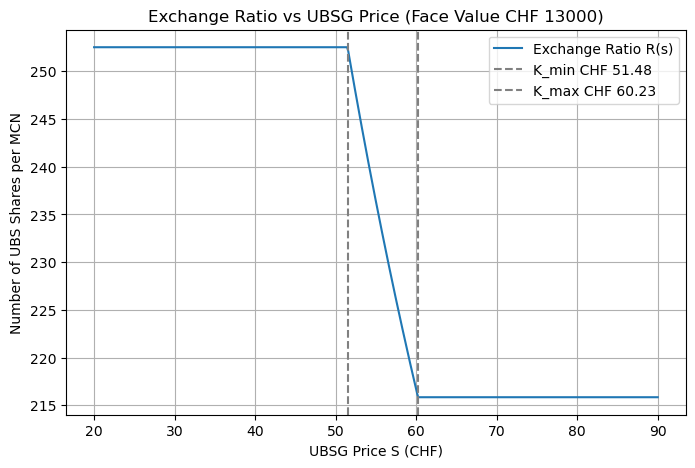

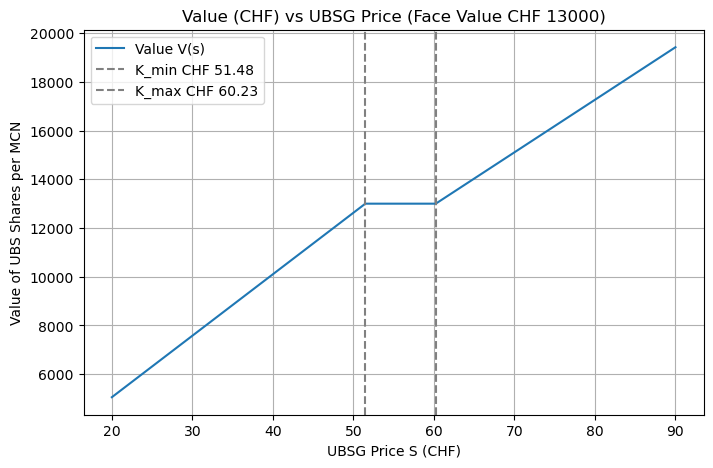

In [81]:
S = np.linspace(20, 90, 500)
F = 13000
K_min = 51.48 
K_max = 60.23
R = np.piecewise(S,
    [S < K_min, (S >= K_min) & (S <= K_max), S > K_max], 
    [F/K_min, lambda s: F/s, F/K_max]
)
V = R * S 

#plot the number of shares for face value of 1000 and price at maturity 

plt.figure(figsize=(8,5))
plt.plot(S, R, label="Exchange Ratio R(s)")
plt.axvline(51.48, color='gray', linestyle='--', label="K_min CHF 51.48")
plt.axvline(60.23, color='gray', linestyle='--', label="K_max CHF 60.23")
plt.xlabel("UBSG Price S (CHF)")
plt.ylabel("Number of UBS Shares per MCN")
plt.title("Exchange Ratio vs UBSG Price (Face Value CHF 13000)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(S, V, label="Value V(s)") 
plt.axvline(51.48, color='gray', linestyle='--', label="K_min CHF 51.48")
plt.axvline(60.23, color='gray', linestyle='--', label="K_max CHF 60.23")
plt.xlabel("UBSG Price S (CHF)")
plt.ylabel("Value of UBS Shares per MCN")
plt.title("Value (CHF) vs UBSG Price (Face Value CHF 13000)")
plt.legend()
plt.grid(True)
plt.show()



### 2b

Estimate volatility of UBSG: they pay a dividend of CHF 2.20 on April 19, 2007. We adjust the close prices

In [82]:
ubsg_df = pd.read_excel('data/UBSG.xlsx')
ubsg_df.head()

,Date,Open,High,Low,Close,Volume
0,2007-03-05,69.75,71.1000,69.50,70.7000,13786440
1,2007-03-06,70.85,70.8999,69.85,70.3999,12777904
2,2007-03-07,70.50,71.5000,70.20,71.1500,11949739
3,2007-03-08,71.85,72.6000,71.55,72.4000,9867297
4,2007-03-09,72.40,72.6000,71.60,71.9000,10228246


Adjust the closing price and compute the volatility

In [178]:
df = ubsg_df.copy() 
df = df[(df['Date'] >= '2007-03-05') & (df['Date'] < '2008-03-08')]
df['adj_close'] = np.where(df['Date'] == '2007-04-19', df['Close'] + 2.20, df['Close']) 

df['log_return'] = np.log(df['adj_close'] / df['Close'].shift(1)) 
df = df.dropna()

var = df['log_return'].var()
annual_vol = df['log_return'].std() * np.sqrt(252)
h = 1/252
annualized_var = var * 1/h
print("The Variance Rate from 03/05/2007 to 03/05/2008 for UBSG: ", round(var,4))
print("Annualized Variance Rate: ", round(annualized_var,4))
print("The volatility from from 03/05/2007 to 03/05/2008 for UBSG: ", round(np.sqrt(var),4))
print("Annualized volatility: ", round(np.sqrt(annualized_var),4))

The Variance Rate from 03/05/2007 to 03/05/2008 for UBSG:  0.0004
Annualized Variance Rate:  0.1087
The volatility from from 03/05/2007 to 03/05/2008 for UBSG:  0.0208
Annualized volatility:  0.3297


### 2c

Assume no early exercise allowed, compute the value of the MCN 

1. there was a dividend paid out on apr 19, 2007

In [304]:
r = 0.025 # risk free rate
h = 1/252 #time step
T = 2.0 #maturity
sigma = df['log_return'].std() * np.sqrt(1/h) #annualized vol
u = np.exp(sigma * np.sqrt(h)) # up 
d = 1/u #down 
p_star = (np.exp(r*h)-d)/(u-d) #probability 
F = 13000.0
N = int(T/h) #number of steps

print("Up factor u: ", round(u,4))
print("Down factor d: ", round(d,4))
print("Risk-neutral up probability p*: ", round(p_star,4))
print("Timestep N: ", N)

Up factor u:  1.021
Down factor d:  0.9794
Risk-neutral up probability p*:  0.4972
Timestep N:  504


In [305]:
def payoff(ST):
    K_min = 51.48 
    K_max = 60.23
    if ST < K_min: 
        return ST * (F / K_min)
    elif ST <= K_max and ST >= K_min:  
        return F 
    else: 
        return ST * (F / K_max)

In [331]:
def compute_mcn_value_european(S0, r, T, u, d, p_star, N, F, coupons): 
    def geom_prob(n,j): 
        return comb(n,j) * p_star**(n-j) * (1-p_star)**j

    pv_coupons = [C * np.exp(-r * t) for (t, C) in coupons] 
    pv_coupons = sum(pv_coupons)

    constant_term = np.exp(-r*T)
    option_price = 0.0

    for j in range(N+1): 
        ST = S0 * (u**(N-j)) * (d**j)
        option_price += geom_prob(N,j) * (payoff(ST))

    return constant_term * option_price + pv_coupons

In [372]:
def compute_mcn_value(S0, r, T, u, d, p_star, N, F, coupons, early_conversion=False, early_window_start=0, early_window_end=0, boundary=False): 
    #with early conversion 

    #initialize the coupons
    coupon_map = {}
    for (t, D) in coupons: 
        k = int(round(t/h))
        coupon_map[k] = coupon_map.get(k,0.0) + float(D) 
    
    #set the up and down price lattice
    S = [[0.0] * (i+1) for i in range(N+1)]
    for i in range(N+1): 
        for j in range(i+1): 
            S[i][j] = S0 * (u**(i-j)) * (d**j)

    C = [[0.0] * (i+1) for i in range(N+1)]
    EX = [[False] * (i+1) for i in range(N+1)] 

    #initialize terminal nodes
    for k in range(N+1): 
        C[N][k] = payoff(S[N][k]) + (0.09 * 13000.0)

    #compute the values backward induction 

    for x in range(N-1, -1, -1): 
        C_next = coupon_map.get(x, 0.0)
        for y in range(x+1):
            continue_value = (p_star * C[x+1][y] + ((1-p_star) * C[x+1][y+1]))/np.exp(r*h) + C_next

            if early_conversion: 
                if early_window_start <= x <= early_window_end: 
                    C[x][y] = max(continue_value, F) 
                    if continue_value < F: 
                        EX[x][y] = True
                else: 
                    C[x][y] = continue_value 
                    EX[x][y] = False
            else: 
                C[x][y] = continue_value 
                EX[x][y] = False
    if not boundary: 
        return C[0][0]

    #compute the exercise boundary if needed 
    t_vals = [] 
    s_vals = []
    for i in range(early_window_start, early_window_end+1): 
        boundary_price = None 
        for j in range(i+1): 
            if EX[i][j] == True:
                boundary_price = S[i][j]
                break 
        if boundary_price is not None: 
            t_vals.append(i*h)
            s_vals.append(boundary_price)


    return C[0][0], t_vals, s_vals
 

### 2c

In [352]:
c_0 = compute_mcn_value_european(32.24, r, T, u, d, p_star, N, F, [(1.0,0.09*13000), (2.0, 0.09*13000)])
print("For our variable inputs, the value of the MCN on March 5th, 2008 is", round(c_0,4))

For our variable inputs, the value of the MCN on March 5th, 2008 is 10152.2199


### 2f

Compute delta_0 and beta_0

In [353]:
new_coupons = remaining_coupons([(1.0,0.09*13000),(2.0,0.09*13000)], h)
S_up = 32.24 * u
S_down = 32.24 * d
print(S_up) 
print(S_down)
print("The fair value of the MCN for c_1,0 is", 
compute_mcn_value_european(S_up, r, T-h, u, d, p_star, N-1, F, new_coupons))
print("The fair value of the MCN for c_1,1 is ", 
compute_mcn_value_european(32.24*d, r, T-h, u, d, p_star, N-1, F, new_coupons))

32.91659512177148
31.577312178090843
The fair value of the MCN for c_1,0 is 10303.184080866307
The fair value of the MCN for c_1,1 is  10004.942645379466


In [354]:
def compute_delta_beta(i,j, S0, r, T, u, d, p_star, N, F, coupons):
    new_coupons = remaining_coupons(coupons, (i+1)*h)
    S_ij = S0 * (u**(i-j)) * (d**j) 

    S_up = S_ij * u 
    S_down = S_ij * d 

    T_rem = T - (i+1)*h 
    N_rem = N - (i+1)

    C_up = compute_mcn_value_european(S_up, r, T_rem, u, d, p_star, N_rem, F, new_coupons)
    C_down = compute_mcn_value_european(S_down, r, T_rem, u, d, p_star, N_rem, F, new_coupons)

    delta = (C_up - C_down) / (S_ij*(u-d))
    beta = (C_up * d  - C_down * u) / (u-d) * np.exp(-r*h) * -1
    return delta, beta


In [355]:
delta_0, beta_0 = compute_delta_beta(0,0, 32.24, r, T, u, d, p_star, N, F, [(1.0,0.09*13000),(2.0,0.09*13000)])
print("delta, beta: ", (delta_0, beta_0)) 

delta, beta:  (222.68739917437463, 2972.7781904224357)


In [356]:
S0 = 32.24 
computed_c0 = delta_0 * S0 + beta_0 
print("Computed c_0 from delta and beta: ", round(computed_c0,4))
print("Actual c_0: ", round(c_0,4))

Computed c_0 from delta and beta:  10152.2199
Actual c_0:  10152.2199


### 2g

we edit our mcn function to account for early conversion

In [375]:
fig2_val, t_vals, s_star = compute_mcn_value(32.24, r, T, u, d, p_star, N, F, [(1.0, 0.09*13000)], 
early_conversion=True, early_window_start=126, early_window_end=483, boundary=True)
print("The fair value of the MCN with early conversion option is: ", round(fig2_val,4))

The fair value of the MCN with early conversion option is:  14068.989


### 2h

Plot the exercise boundary

In [378]:
t_vals_months = [t * 12 for t in t_vals]
t_vals_months = [t-12 for t in t_vals_months]

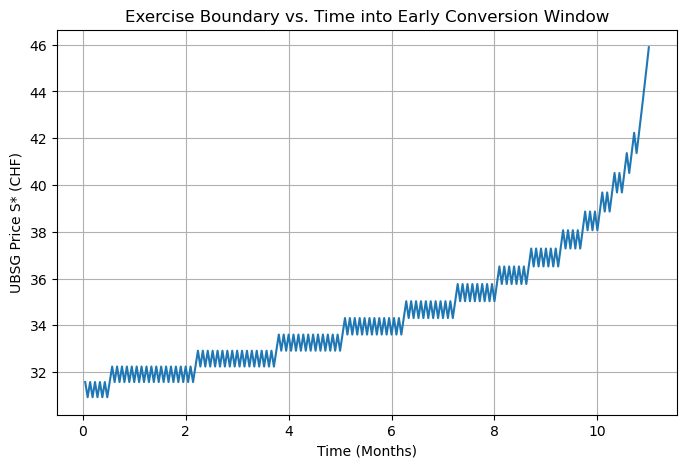

In [380]:
plt.figure(figsize=(8,5))
plt.plot(t_vals_months, s_star, label="Exercise Boundary S*")
plt.title("Exercise Boundary vs. Time into Early Conversion Window")
plt.xlabel("Time (Months)")
plt.ylabel("UBSG Price S* (CHF)")
plt.grid()
plt.show() 